![LogoTec](img/logoTec.png)

# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks
## José Antonio Cantoral Ceballos, Ph.D.
## Team Members:
- A01200230 - Armando Bringas Corpus

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


### Import Libraries

In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


In [2]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
DATA_PATH = 'data/asl_data/'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Load Data

In [4]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

### Train and validation data


In [5]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into validation and test.
    '''
    # verify that x_val and y_val have the same length
    assert len(x) == len(y)

    # total of data
    total_data = len(x)

    # shuffle data if it is required
    if shuffle:
        indices = np.arange(len(x))
        np.random.shuffle(indices)
        x, y = map(lambda data: np.array([data[i] for i in indices]), [x, y])

    # calculate split index
    split_idx = int(pct * len(x))
    
    return x[:split_idx], y[:split_idx].reshape(-1,1), x[split_idx:], y[split_idx:].reshape(-1,1)

In [6]:
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

Inspect shape of the splitted data

In [7]:
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)


(27455, 784)
(27455,)
(3586, 784)
(3586, 1)
(3586, 784)
(3586, 1)


In [8]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

Lambda function that applies feature scaling to the dataset x_data using the mean x_mean and standard deviation x_std. Feature scaling is a method used to standardize the range of independent variables or features of data.

In [9]:
normalise = lambda x_mean, x_std, x_data: (x_data - x_mean) / x_std

x_mean = x_train.mean()
x_std = x_train.std()

x_train = normalise(x_mean, x_std, x_train)
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [10]:
x_train.mean(), x_train.std()

(3.6268384e-06, 0.99999946)

### Plot Samples

In [11]:
def plot_number(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

Plot a random sample

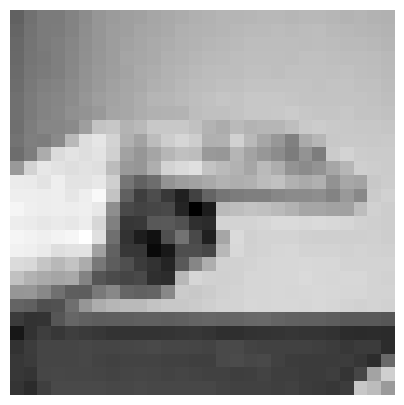

La imagen muestreada representa un: h


In [12]:
rnd_idx = np.random.randint(len(y_test))
image_data = x_test[rnd_idx].reshape(28, 28)
plot_number(image_data)

print(f'La imagen muestreada representa un: {alphabet[y_test[rnd_idx][0]]}')

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Funciones adicionales

#### Mini batches

In [13]:
#Function to create training minibatches
def create_minibatches(mb_size, x, y, shuffle = True):
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras'
    total_data = x.shape[0]
    # Shuffle the dataset if the shuffle parameter is True
    if shuffle:
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        # Shuffled indices to reorder the input features and labels
        x = x[idxs]
        y = y[idxs]
    # Generate minibatches
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Nuestra clase Linear, ReLU y Sequential

In [14]:
class np_tensor(np.ndarray): pass

###  Clase Linear

In [15]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        Init parameters utilizando Kaiming He
        '''
        # Initialize the weights using Kaiming He initialization for better performance with the ReLU activations
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)
        # Initialize biases with zeros
        self.b = (np.zeros((output_size, 1))).view(np_tensor)
    def __call__(self, X):
        # Forward pass linear transformation
        Z = self.W @ X + self.b
        return Z
    def backward(self, X, Z):
        # Get the gradient with respect to the input
        X.grad = self.W.T @ Z.grad
        # Get the gradient with respect to the weights
        self.W.grad = Z.grad @ X.T
        # Get the gradient with respect to the biases
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)    

### Clase ReLU

In [16]:
class ReLU():
    def __call__(self, Z):
        # ReLU activation that replaces negative values in Z with 0
        return np.maximum(0, Z)
    def backward(self, Z, A):
        # Copy the gradient from the next layer
        Z.grad = A.grad.copy()
        # Zero the gradient where the function is not activated
        Z.grad[Z <= 0] = 0
        Z.grad[Z <= 0] = 0

### Clase Sequential

In [17]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        layers - lista que contiene objetos de tipo Linear, ReLU
        '''
        self.layers = layers
        self.x = None
        self.outputs = {}
    def __call__(self, X):
        self.x = X 
        self.outputs['l0'] = self.x
        # Forward pass through each layer
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x
        # Return the output for backpropagation
        return self.x
    def backward(self):
        for i in reversed(range(len(self.layers))):
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])
    def update(self, learning_rate = 1e-3):
        for layer in self.layers:
            if isinstance(layer, ReLU): continue
            # Update weights and biases with gradient descent
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad
    def predict(self, X):
        # Forward pass and return the index of the max value
        return np.argmax(self.__call__(X)) 

### Cost Function

In [18]:
def softmaxXEntropy(x, y):
    batch_size = x.shape[1]
    
    # Compute the exponential scores for numerical stability in softmax
    # Compute the probabilities for each class by normalizing the exponential scores
    exp_scores = np.exp(x)
    probs = exp_scores / exp_scores.sum(axis = 0)
    preds = probs.copy()
    
    # Compute the cross-entropy cost
    y_hat = probs[y.squeeze(), np.arange(batch_size)]
    cost = np.sum(-np.log(y_hat)) / batch_size
    
    # Calculate gradients for backpropagation
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()
    
    return preds, cost

### Training Function

In [19]:
#Function for training the model
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    # Iterate over each epoch
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            # Perform a forward pass and compute score
            scores = model(x.T.view(np_tensor))
            # Calculate the cost and gradients with respect score
            _, cost = softmaxXEntropy(scores, y)
            # Perform backward pass and then update learning rate
            model.backward()
            model.update(learning_rate)

        print(f'epochs: {epoch+1}\t cost: {cost:.4f} \t accuracy: {accuracy(x_val, y_val, mb_size, model):.4f}')

### Accuracy Function

In [20]:
#Function to calculate the model accuracy
def accuracy(x, y, mb_size, model):
    correct = 0
    total = 0
    # Iterate over dataset in minibatches
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):
        # Perform forward pass to get predictions from the model
        pred = model(x.T.view(np_tensor))
        # Count how many predictions match with the true labels and get the total
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())
        total += pred.shape[1]
        
    # Handle the case where total is zero to avoid division by zero
    if total == 0:
        return 0  # or return an appropriate value or message indicating no data was processed
    
    return correct/total

### Create your model and train it

Model Hyperparameters

In [21]:
# Constants
BATCH_SIZE = 512
INPUT_DIM = x_train.shape[1]
OUTPUT_DIM = len(alphabet)
NEURONS = [300, 500, 700]
LEARNING_RATES = [1e-3, 5e-4, 1e-4]
EPOCHS = 20

Neural Network Architecture:

Input -> Linear -> ReLU -> Linear -> ReLU -> Linear -> ReLU -> Linear -> Output

This type of architecture is common in feedforward neural networks, where the goal is to transform the input data through successive layers of computation to make a prediction. ReLU activation functions are used to help combat the vanishing gradient problem, which allows the network to learn faster and perform better on a variety of tasks.

The intention is to test with different combinations of model hyperparameters to determine which performs best.

In [22]:
# Store models' accuracy for different configurations
models_accuracy = {}

# Initialize the best model and its accuracy
best_model = None
best_accuracy = 0

# Train different model configurations
for lr in LEARNING_RATES:
    for neuron_count in NEURONS:
        print('\n' + '-' * 60)
        print(f'Training with Neurons: {neuron_count}, Learning Rate: {lr}')
        print('-' * 60)
        
        # Create the model
        model = Sequential_layers([
            Linear(INPUT_DIM, neuron_count), 
            ReLU(), 
            Linear(neuron_count, neuron_count),
            ReLU(), 
            Linear(neuron_count, neuron_count),
            ReLU(), 
            Linear(neuron_count, OUTPUT_DIM)
        ])
        
        # Train the model
        trained_model = train(model, EPOCHS, BATCH_SIZE, lr)
        
        # Calculate accuracy on the test set
        test_acc = accuracy(x_test, y_test, BATCH_SIZE, model)
        print(f'\nAccuracy: {test_acc:.4f}')
        
        models_accuracy[(lr, neuron_count)] = test_acc
        
        # Update the best model if the current model is better
        if test_acc > best_accuracy:
            best_accuracy = test_acc
            best_model = trained_model

# Print the best model's accuracy
print('\n' + '-' * 60)
print(f"\nBest Model Accuracy: {best_accuracy:.4f}")


------------------------------------------------------------
Training with Neurons: 300, Learning Rate: 0.001
------------------------------------------------------------
epochs: 1	 cost: 0.2524 	 accuracy: 0.7390
epochs: 2	 cost: 0.0117 	 accuracy: 0.7711
epochs: 3	 cost: 0.0057 	 accuracy: 0.7777
epochs: 4	 cost: 0.0029 	 accuracy: 0.7800
epochs: 5	 cost: 0.0024 	 accuracy: 0.7836
epochs: 6	 cost: 0.0014 	 accuracy: 0.7836
epochs: 7	 cost: 0.0015 	 accuracy: 0.7850
epochs: 8	 cost: 0.0013 	 accuracy: 0.7850
epochs: 9	 cost: 0.0012 	 accuracy: 0.7858
epochs: 10	 cost: 0.0009 	 accuracy: 0.7869
epochs: 11	 cost: 0.0006 	 accuracy: 0.7881
epochs: 12	 cost: 0.0006 	 accuracy: 0.7889
epochs: 13	 cost: 0.0006 	 accuracy: 0.7883
epochs: 14	 cost: 0.0006 	 accuracy: 0.7889
epochs: 15	 cost: 0.0005 	 accuracy: 0.7900
epochs: 16	 cost: 0.0005 	 accuracy: 0.7881
epochs: 17	 cost: 0.0004 	 accuracy: 0.7895
epochs: 18	 cost: 0.0004 	 accuracy: 0.7900
epochs: 19	 cost: 0.0003 	 accuracy: 0.7892
e

### Test your model on Random data from your test set

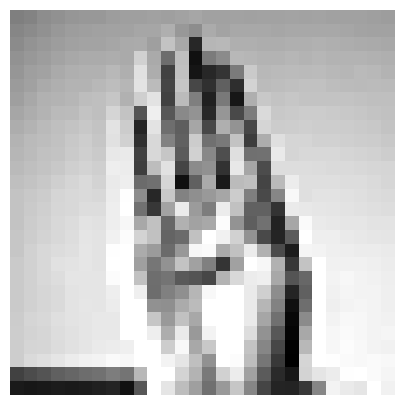

el valor predicho es: b el valor real es:b


In [23]:
idx = np.random.randint(len(y_test))
plot_number(x_test[idx].reshape(28,28))
pred = model.predict(x_test[idx].reshape(-1, 1))

print(f'el valor predicho es: {alphabet[pred]} el valor real es:{alphabet[y_test[idx][0]]}')